In [13]:
# Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy.stats import shapiro

# Statistical Modeling and Machine Learning
from scipy import stats
from scipy.stats import ttest_ind


In [14]:
fangraphs_data = pd.read_csv("fangraphs_season_level.csv")
savant_data = pd.read_csv("savant_pitch_level.csv")

In [16]:
# Define thresholds
threshold_g_MR = 21  # 50th percentile
threshold_gs_MR = 1  # Slightly above minimum
min_ip_MR = 16.1     # 25th percentile
max_ip_MR = 112.1    # 75th percentile
threshold_percentage_LS = 0.75  # Hypothetical value, adjust based on your analysis
threshold_gmli_SU = 0.955314  # 75th percentile
threshold_hld_SU = 1          # 75th percentile

threshold_sv_CL = 20  # High number of saves for Closers
min_ip_LR = 40        # Minimum innings pitched for Long Relievers
balance_threshold_SW = 0.3  # Minimum balance ratio of GS to (G-GS) for Swingmen



# Closer
def is_closer(row):
    return row['SV'] > threshold_sv_CL

# Long Reliever
def is_long_reliever(row):
    return (row['IP'] > min_ip_LR) and not is_middle_reliever(row)

# Swingman
def is_swingman(row):
    return row['GS'] / max(row['G'] - row['GS'], 1) > balance_threshold_SW

# Middle Reliever
def is_middle_reliever(row):
    return row['G'] > threshold_g_MR and row['GS'] < threshold_gs_MR and min_ip_MR <= row['IP'] <= max_ip_MR

# Lefty Specialist
def is_lefty_specialist(player_id):
    left_handed_batters_faced = savant_data[savant_data['stand'] == 'L'].groupby('pitcher').size().get(player_id, 0)
    total_batters_faced = savant_data.groupby('pitcher').size().get(player_id, 1)  # avoid division by zero
    percentage_left_handed_batters_faced = left_handed_batters_faced / total_batters_faced
    return percentage_left_handed_batters_faced > threshold_percentage_LS

# Setup Man
def is_setup_man(row):
    return row['gmLI'] > threshold_gmli_SU and row['HLD'] > threshold_hld_SU

fangraphs_data['additional_role'] = fangraphs_data.apply(
    lambda row: 'Middle Reliever' if is_middle_reliever(row) else
                'Lefty Specialist' if is_lefty_specialist(row['MLBAMID']) else
                'Setup Man' if is_setup_man(row) else
                'Closer' if is_closer(row) else
                'Long Reliever' if is_long_reliever(row) else
                'Swingman' if is_swingman(row) else
                'Other', axis=1)

# Review the categorization
print(fangraphs_data['additional_role'].value_counts())


additional_role
Other               1245
Middle Reliever      845
Long Reliever        594
Swingman             560
Setup Man             69
Lefty Specialist      12
Name: count, dtype: int64


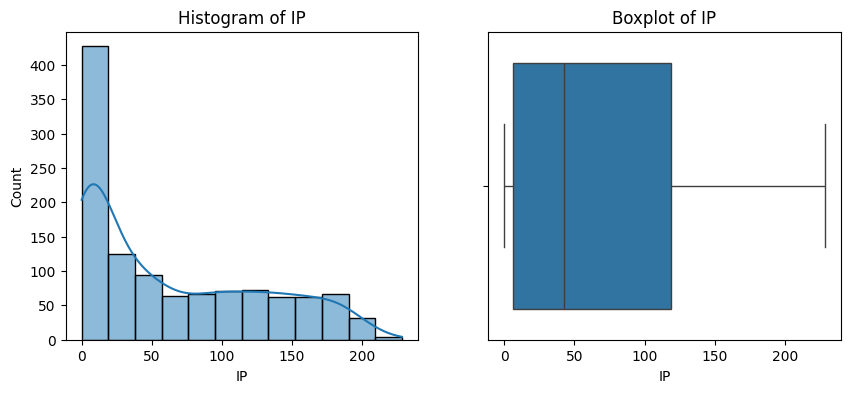

Shapiro-Wilk Test for IP - Statistics=0.8670504843333946, p=4.259446440086483e-30
Sample does not look Gaussian (not normally distributed).
Mean for IP: 64.96204188481676
Median for IP: 42.2

---



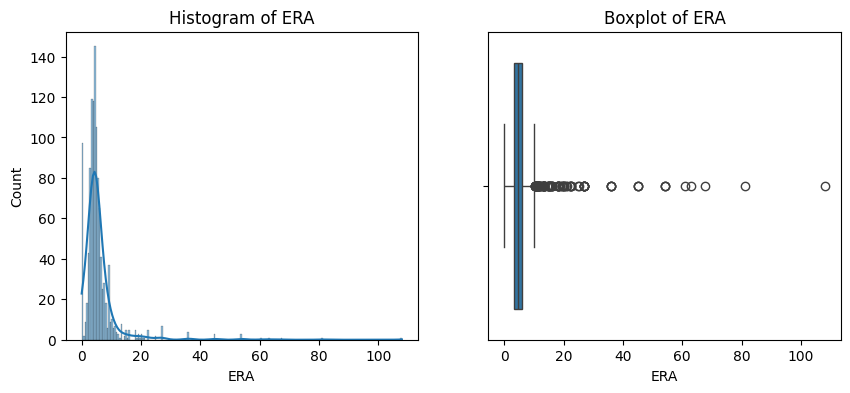

Shapiro-Wilk Test for ERA - Statistics=0.4695305906662963, p=9.339282955555965e-50
Sample does not look Gaussian (not normally distributed).
Mean for ERA: 5.803644106579407
Median for ERA: 4.5

---



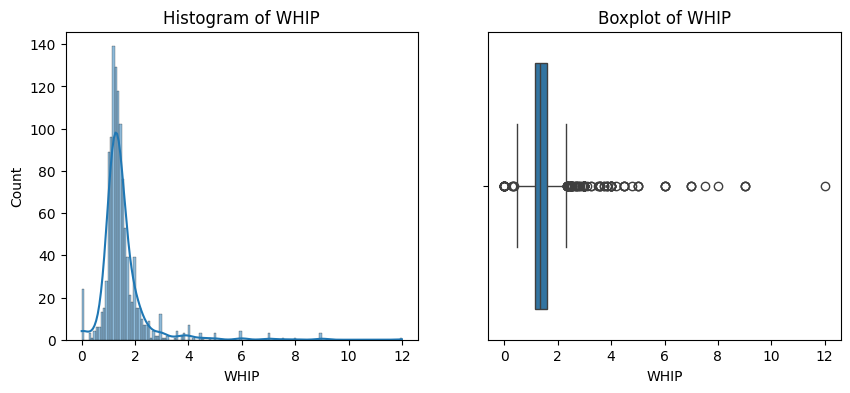

Shapiro-Wilk Test for WHIP - Statistics=0.600403952595189, p=2.586252215984351e-45
Sample does not look Gaussian (not normally distributed).
Mean for WHIP: 1.5173324076727748
Median for WHIP: 1.333333333

---



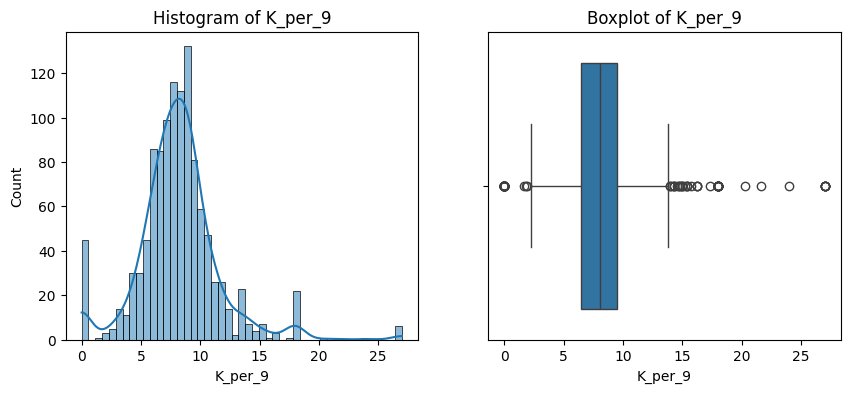

Shapiro-Wilk Test for K_per_9 - Statistics=0.9019229345675983, p=1.8379329030464074e-26
Sample does not look Gaussian (not normally distributed).
Mean for K_per_9: 8.182956809201572
Median for K_per_9: 8.059713653

---



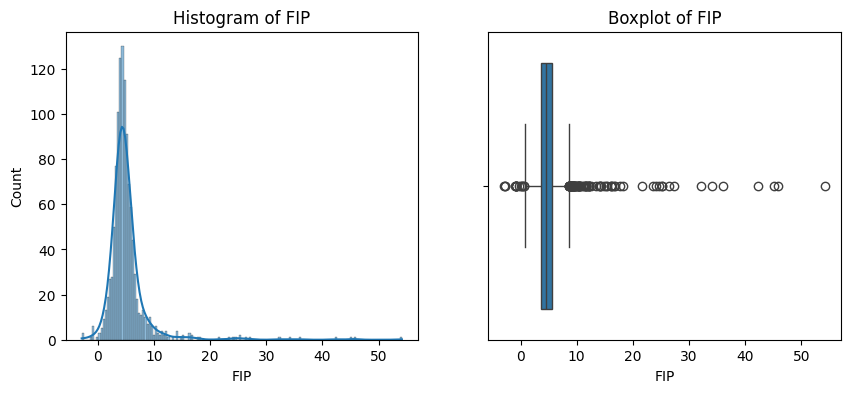

Shapiro-Wilk Test for FIP - Statistics=0.5337240264202432, p=1.0459419220163185e-47
Sample does not look Gaussian (not normally distributed).
Mean for FIP: 5.155993918172775
Median for FIP: 4.4806284055

---



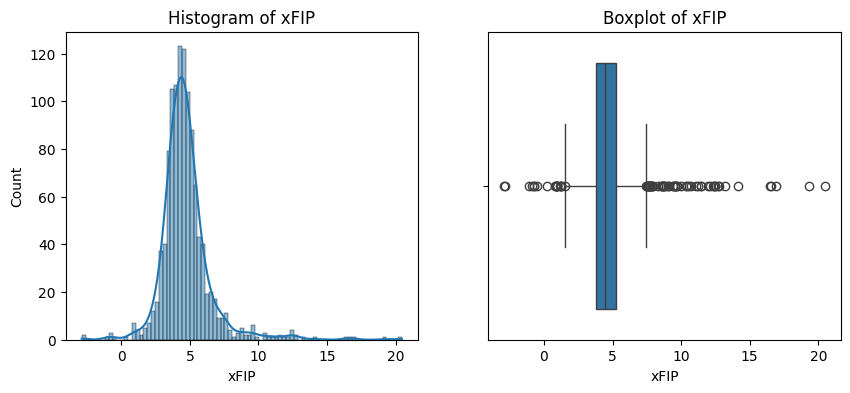

Shapiro-Wilk Test for xFIP - Statistics=0.7997962059740361, p=2.2260988291671308e-35
Sample does not look Gaussian (not normally distributed).
Mean for xFIP: 4.707606318438918
Median for xFIP: 4.482097994

---



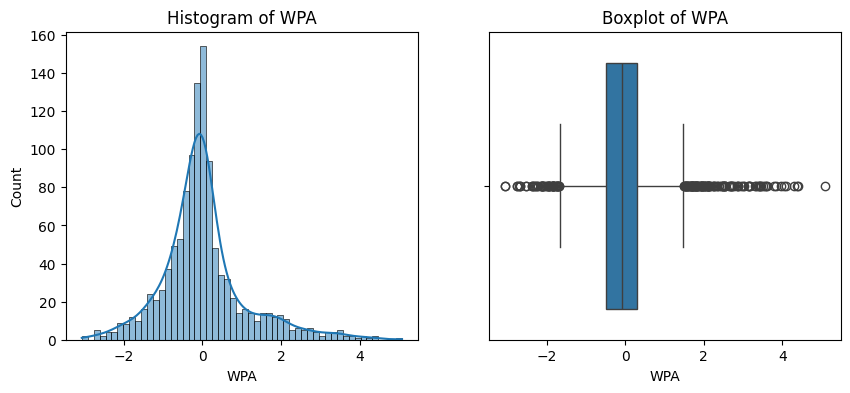

Shapiro-Wilk Test for WPA - Statistics=0.9209492401595646, p=4.915036860793411e-24
Sample does not look Gaussian (not normally distributed).
Mean for WPA: 0.023287459227748688
Median for WPA: -0.0752770005

---



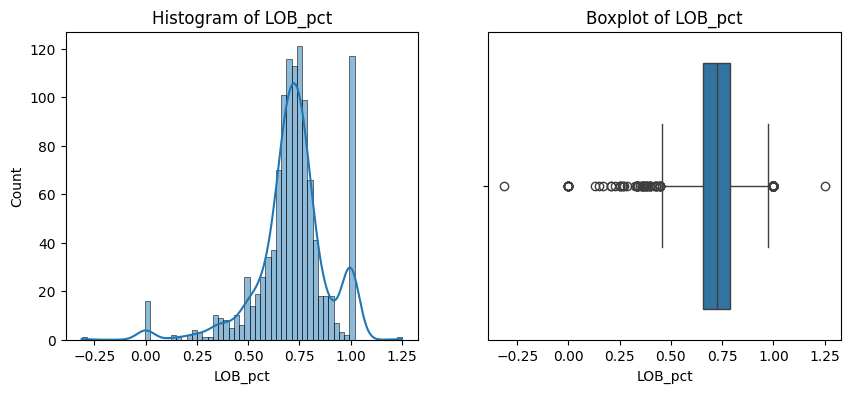

Shapiro-Wilk Test for LOB_pct - Statistics=0.8952289064771979, p=3.1363934197650335e-27
Sample does not look Gaussian (not normally distributed).
Mean for LOB_pct: 0.7142422338568936
Median for LOB_pct: 0.72245

---



In [50]:
#Starting pitcher success analysis
starting_pitchers = fangraphs_data[fangraphs_data['Role'] == 'SP']
metrics_sp = ['IP', 'ERA', 'WHIP', 'K_per_9', 'FIP', 'xFIP', 'WPA', 'LOB_pct']

# Visualizing the distribution of each metric
for metric in metrics_sp:
    plt.figure(figsize=(10, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(starting_pitchers[metric], kde=True)
    plt.title(f'Histogram of {metric}')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=starting_pitchers[metric])
    plt.title(f'Boxplot of {metric}')

    plt.show()

    # Shapiro-Wilk Test
    stat, p = shapiro(starting_pitchers[metric].dropna())
    print(f'Shapiro-Wilk Test for {metric} - Statistics={stat}, p={p}')
    if p > 0.05:
        print('Sample looks Gaussian (normal distribution).')
    else:
        print('Sample does not look Gaussian (not normally distributed).')

    # Compare Mean and Median
    mean_value = starting_pitchers[metric].mean()
    median_value = starting_pitchers[metric].median()
    print(f'Mean for {metric}: {mean_value}')
    print(f'Median for {metric}: {median_value}')
    print('\n---\n')



In [51]:
sp_metrics_summary = starting_pitchers[['IP', 'ERA', 'WHIP', 'K_per_9', 'FIP', 'xFIP', 'WPA', 'LOB_pct']].median()


In [52]:
sp_ids = starting_pitchers['MLBAMID'].unique()
sp_pitches = savant_data[savant_data['pitcher'].isin(sp_ids)]
sp_pitch_types = sp_pitches.groupby(['pitcher', 'pitch_type']).size().unstack().fillna(0)
sp_velocity = sp_pitches.groupby('pitcher')['release_speed'].mean()
sp_spin_rate = sp_pitches.groupby('pitcher')['release_spin_rate'].mean()


sp_velocity = sp_velocity.reset_index()
sp_spin_rate = sp_spin_rate.reset_index()

sp_velocity = sp_velocity.rename(columns={'pitcher': 'MLBAMID'})
sp_spin_rate = sp_spin_rate.rename(columns={'pitcher': 'MLBAMID'})


starting_pitchers = starting_pitchers.merge(sp_pitch_types, left_on='MLBAMID', right_index=True, how='left')
starting_pitchers = starting_pitchers.merge(sp_velocity, on='MLBAMID', how='left')
starting_pitchers = starting_pitchers.merge(sp_spin_rate, on='MLBAMID', how='left')


In [53]:
# Define success criteria based on multiple metrics for Starting Pitchers
success_criteria_sp = (
    (starting_pitchers['IP'] >= sp_metrics_summary['IP']) &
    (starting_pitchers['ERA'] <= sp_metrics_summary['ERA']) &
    (starting_pitchers['WHIP'] <= sp_metrics_summary['WHIP']) &
    (starting_pitchers['K_per_9'] >= sp_metrics_summary['K_per_9']) &
    (starting_pitchers['FIP'] <= sp_metrics_summary['FIP']) &
    (starting_pitchers['xFIP'] <= sp_metrics_summary['xFIP']) &
    (starting_pitchers['WPA'] >= sp_metrics_summary['WPA']) &
    (starting_pitchers['LOB_pct'] >= sp_metrics_summary['LOB_pct'])
)
# Filter successful and less successful Starting Pitchers
successful_sp = starting_pitchers[success_criteria_sp]
less_successful_sp = starting_pitchers[~success_criteria_sp]

metrics_sp = ['IP', 'ERA', 'WHIP', 'K_per_9', 'FIP', 'xFIP', 'WPA', 'LOB_pct']


for metric in metrics_sp:
    median_successful = successful_sp[metric].median()
    median_less_successful = less_successful_sp[metric].median()
    print(f"Median {metric} for successful SP: {median_successful}")
    print(f"Median {metric} for less successful SP: {median_less_successful}")
    print('\n---\n')


Median IP for successful SP: 156.6
Median IP for less successful SP: 30.15

---

Median ERA for successful SP: 3.1717310815
Median ERA for less successful SP: 4.766388972

---

Median WHIP for successful SP: 1.1099033815000001
Median WHIP for less successful SP: 1.389486493

---

Median K_per_9 for successful SP: 9.621439574
Median K_per_9 for less successful SP: 7.703848970499999

---

Median FIP for successful SP: 3.5026758439999996
Median FIP for less successful SP: 4.693229818500001

---

Median xFIP for successful SP: 3.5939335925
Median xFIP for less successful SP: 4.6475021425000005

---

Median WPA for successful SP: 1.7053899764999998
Median WPA for less successful SP: -0.1484339985

---

Median LOB_pct for successful SP: 0.77485
Median LOB_pct for less successful SP: 0.70445

---



In [54]:
successful_sp

,PlayerId,MLBAMID,Name,NameASCII,Throws,Season,Age,Team,Role,G,...,KC,KN,PO,SC,SI,SL,ST,SV_y,release_speed,release_spin_rate
4,2520,458681,Lance Lynn,Lance Lynn,R,2021,34,CHW,SP,28,...,0.0,0.0,0.0,0.0,1154.0,244.0,5.0,0.0,90.285725,2410.937190
6,3137,453286,Max Scherzer,Max Scherzer,R,2021,36,- - -,SP,30,...,0.0,0.0,0.0,0.0,0.0,1464.0,0.0,0.0,88.533074,2273.108293
42,10310,554430,Zack Wheeler,Zack Wheeler,R,2021,31,PHI,SP,32,...,0.0,0.0,0.0,0.0,1560.0,0.0,387.0,0.0,92.762446,2422.885839
47,10954,594798,Jacob deGrom,Jacob deGrom,R,2021,33,NYM,SP,15,...,0.0,0.0,0.0,0.0,0.0,945.0,0.0,0.0,95.492511,2450.074513
59,12304,605135,Chris Bassitt,Chris Bassitt,R,2021,32,OAK,SP,27,...,0.0,0.0,0.0,0.0,3051.0,436.0,704.0,0.0,86.718630,2165.207871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,20633,579328,Yusei Kikuchi,Yusei Kikuchi,L,2023,32,TOR,SP,32,...,0.0,0.0,1.0,0.0,0.0,1774.0,0.0,0.0,90.636555,2254.852407
1109,20778,650911,Cristopher SÃ¡nchez,Cristopher Sanchez,L,2023,26,PHI,SP,18,...,0.0,0.0,0.0,0.0,1212.0,466.0,0.0,0.0,87.926832,1985.151203
1112,21483,663556,Shane McClanahan,Shane McClanahan,L,2023,26,TBR,SP,21,...,0.0,0.0,0.0,0.0,0.0,1338.0,0.0,0.0,90.489676,2225.813293
1115,21844,666129,Braxton Garrett,Braxton Garrett,L,2023,25,MIA,SP,30,...,0.0,0.0,0.0,0.0,1205.0,1233.0,0.0,0.0,86.462027,2148.160853


In [55]:
for metric in metrics_sp:
    stat, p = ttest_ind(successful_sp[metric].dropna(), less_successful_sp[metric].dropna())
    print(f"{metric}: Statistics={stat}, p-value={p}")

IP: Statistics=19.776839628242893, p-value=4.1131151245777734e-75
ERA: Statistics=-4.7874676131094365, p-value=1.9101388481850293e-06
WHIP: Statistics=-5.977927152983095, p-value=3.016014556992813e-09
K_per_9: Statistics=6.5304420505088006, p-value=9.841233859776824e-11
FIP: Statistics=-5.599693754995857, p-value=2.6874208645191398e-08
xFIP: Statistics=-8.454935986900846, p-value=8.409114247730551e-17
WPA: Statistics=28.717032746290222, p-value=5.177078612915283e-137
LOB_pct: Statistics=4.972032601454569, p-value=7.637748219169931e-07


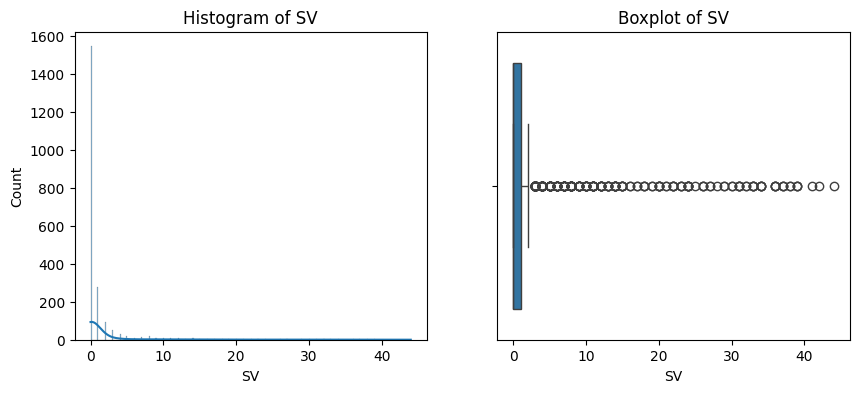

Shapiro-Wilk Test for SV - Statistics=0.345033066064953, p=1.8468654229634137e-66
Sample does not look Gaussian (not normally distributed).
Mean for SV: 1.6815052776502983
Median for SV: 0.0

---



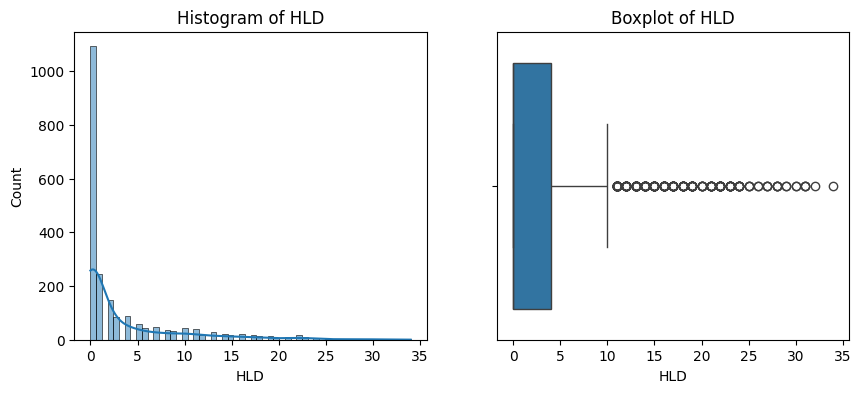

Shapiro-Wilk Test for HLD - Statistics=0.6544327327128103, p=8.04161242793967e-55
Sample does not look Gaussian (not normally distributed).
Mean for HLD: 3.383203304268013
Median for HLD: 0.0

---



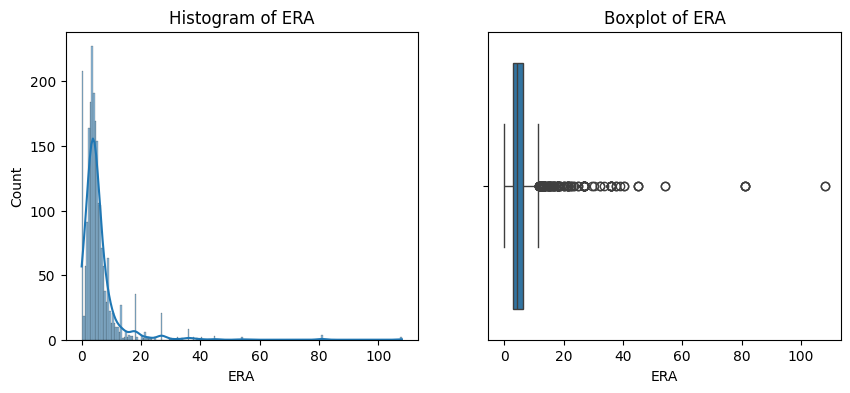

Shapiro-Wilk Test for ERA - Statistics=0.5273841276723499, p=2.2387434998548453e-60
Sample does not look Gaussian (not normally distributed).
Mean for ERA: 5.683069425212943
Median for ERA: 4.183098592

---



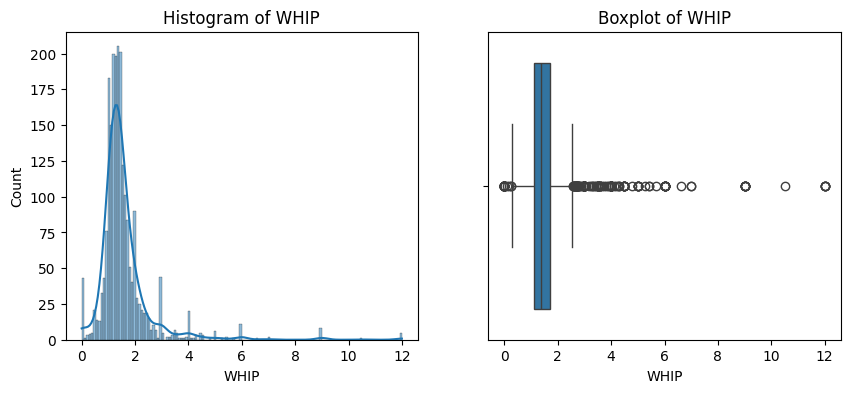

Shapiro-Wilk Test for WHIP - Statistics=0.610572544687054, p=6.573219769447779e-57
Sample does not look Gaussian (not normally distributed).
Mean for WHIP: 1.576985409373566
Median for WHIP: 1.36363887

---



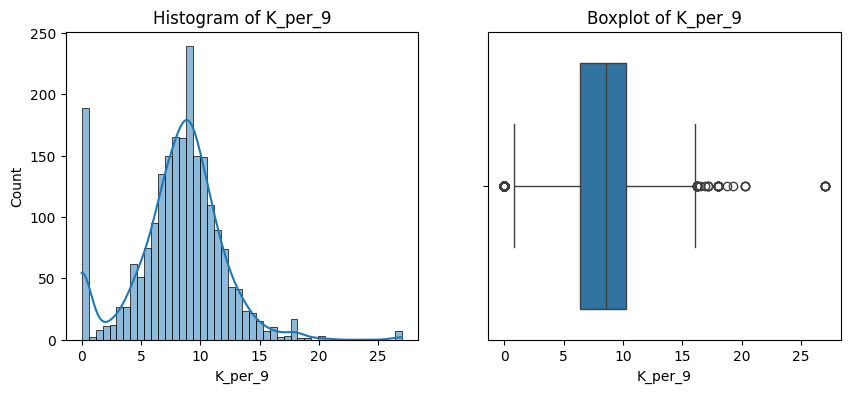

Shapiro-Wilk Test for K_per_9 - Statistics=0.9444630945818528, p=6.837323034713201e-28
Sample does not look Gaussian (not normally distributed).
Mean for K_per_9: 8.100983901522257
Median for K_per_9: 8.526315789

---



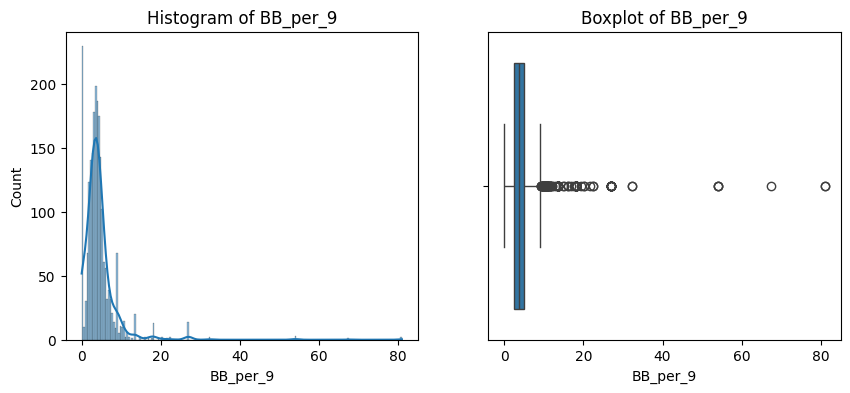

Shapiro-Wilk Test for BB_per_9 - Statistics=0.5401369454671546, p=7.020479275985921e-60
Sample does not look Gaussian (not normally distributed).
Mean for BB_per_9: 4.379838097037632
Median for BB_per_9: 3.688524475

---



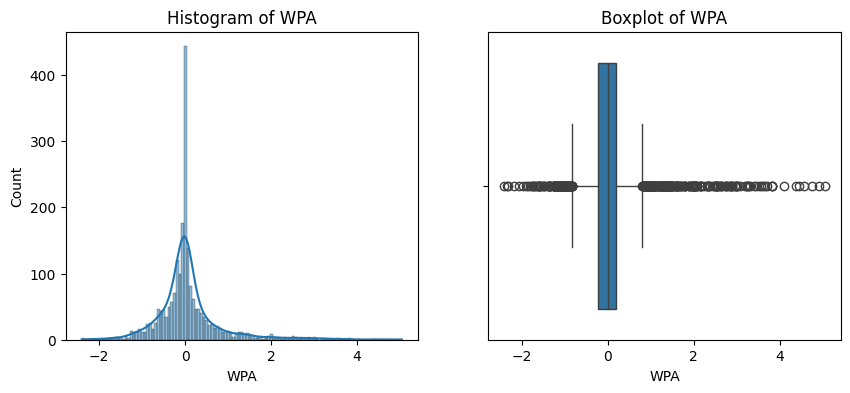

Shapiro-Wilk Test for WPA - Statistics=0.8138693739782761, p=1.18032637980042e-44
Sample does not look Gaussian (not normally distributed).
Mean for WPA: 0.08072554856723267
Median for WPA: -0.000147983

---



In [56]:
relief_pitchers = fangraphs_data[fangraphs_data['Role'] == 'RP']
metrics_rp = ['SV', 'HLD', 'ERA', 'WHIP', 'K_per_9', 'BB_per_9', 'WPA']
for metric in metrics_rp:
    plt.figure(figsize=(10, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(relief_pitchers[metric], kde=True)
    plt.title(f'Histogram of {metric}')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=relief_pitchers[metric])
    plt.title(f'Boxplot of {metric}')

    plt.show()

    # Shapiro-Wilk Test
    stat, p = shapiro(relief_pitchers[metric].dropna())
    print(f'Shapiro-Wilk Test for {metric} - Statistics={stat}, p={p}')
    if p > 0.05:
        print('Sample looks Gaussian (normal distribution).')
    else:
        print('Sample does not look Gaussian (not normally distributed).')

    # Compare Mean and Median
    mean_value = relief_pitchers[metric].mean()
    median_value = relief_pitchers[metric].median()
    print(f'Mean for {metric}: {mean_value}')
    print(f'Median for {metric}: {median_value}')
    print('\n---\n')


In [57]:
rp_metrics_summary = relief_pitchers[metrics_rp].median()




In [58]:
# Get unique MLBAM IDs for Relief Pitchers
rp_ids = relief_pitchers['MLBAMID'].unique()

# Filter the savant_data for pitches thrown by Relief Pitchers
rp_pitches = savant_data[savant_data['pitcher'].isin(rp_ids)]

# Group by pitcher and pitch type, count pitches of each type for each pitcher
rp_pitch_types = rp_pitches.groupby(['pitcher', 'pitch_type']).size().unstack().fillna(0)

# Calculate average velocity and spin rate for each Relief Pitcher
rp_velocity = rp_pitches.groupby('pitcher')['release_speed'].mean()
rp_spin_rate = rp_pitches.groupby('pitcher')['release_spin_rate'].mean()

# Reset index to turn the series into DataFrame
rp_velocity = rp_velocity.reset_index()
rp_spin_rate = rp_spin_rate.reset_index()

# Rename columns for consistency
rp_velocity = rp_velocity.rename(columns={'pitcher': 'MLBAMID'})
rp_spin_rate = rp_spin_rate.rename(columns={'pitcher': 'MLBAMID'})

# Merge pitch type counts, average velocity, and average spin rate with the relief_pitchers DataFrame
relief_pitchers = relief_pitchers.merge(rp_pitch_types, left_on='MLBAMID', right_index=True, how='left')
relief_pitchers = relief_pitchers.merge(rp_velocity, on='MLBAMID', how='left')
relief_pitchers = relief_pitchers.merge(rp_spin_rate, on='MLBAMID', how='left')


In [59]:
# Convert column index to a list and print
column_names = relief_pitchers.columns.tolist()
print(column_names)



['PlayerId', 'MLBAMID', 'Name', 'NameASCII', 'Throws', 'Season', 'Age', 'Team', 'Role', 'G', 'GS', 'IP', 'TBF', 'W', 'L', 'CG', 'ShO', 'SV_x', 'BS', 'HLD', 'SD', 'MD', 'Pulls', 'ERA', 'R', 'ER', 'H', 'HR', 'SO', 'BB', 'IBB', 'HBP', 'WP', 'BK', 'Events', 'GB', 'LD', 'FB', 'IFFB', 'BU', 'IFH', 'BUH', 'Balls', 'Strikes', 'Pitches', 'RS', 'RS_per_9', 'K_pct', 'BB_pct', 'K_minus_BB_pct', 'K_per_9', 'BB_per_9', 'K_to_BB', 'H_per_9', 'HR_per_9', 'AVG', 'WHIP', 'BABIP', 'LOB_pct', 'GB_pct', 'LD_pct', 'FB_pct', 'IFFB_pct', 'GB_to_FB', 'HR_to_FB', 'IFH_pct', 'BUH_pct', 'FIP', 'xFIP', 'SIERA', 'tERA', 'kwERA', 'E_minus_F', 'RAR', 'WAR', 'Dollars', 'WPA', 'RE24', 'REW', 'pLI', 'inLI', 'gmLI', 'exLI', 'WPA_to_LI', 'Clutch', 'OSwing_pct', 'ZSwing_pct', 'Swing_pct', 'OContact_pct', 'ZContact_pct', 'Contact_pct', 'Zone_pct', 'FStrike_pct', 'SwStr_pct', 'CStr_pct', 'CSW_pct', 'ERA_minus', 'FIP_minus', 'xFIP_minus', 'Pace', 'RA9_WAR', 'BIP_Wins', 'LOB_Wins', 'FDP_Wins', 'Pull_pct', 'Cent_pct', 'Oppo_pct

In [60]:
# Define success criteria here
rp_metrics_summary = relief_pitchers[['SV_x', 'HLD', 'ERA', 'WHIP', 'K_per_9', 'BB_per_9', 'WPA']].median().rename('median')

# Define success criteria based on multiple metrics for Relief Pitchers
success_criteria_rp = (
    (relief_pitchers['ERA'] <= rp_metrics_summary['ERA']) &
    (relief_pitchers['WHIP'] <= rp_metrics_summary['WHIP']) &
    (relief_pitchers['SV_x'] >= rp_metrics_summary['SV_x']) &
    (relief_pitchers['HLD'] >= rp_metrics_summary['HLD']) &
    (relief_pitchers['K_per_9'] >= rp_metrics_summary['K_per_9']) &
    (relief_pitchers['BB_per_9'] <= rp_metrics_summary['BB_per_9']) &
    (relief_pitchers['WPA'] >= rp_metrics_summary['WPA'])
)

# Filter successful and less successful Relief Pitchers
successful_rp = relief_pitchers[success_criteria_rp]
less_successful_rp = relief_pitchers[~success_criteria_rp]




# Define the metrics you want to compare. For example:
metrics_rp = ['SV_x', 'HLD', 'ERA', 'WHIP', 'K_per_9', 'BB_per_9', 'WPA']

for metric in metrics_rp:
    median_successful = successful_rp[metric].median()
    median_less_successful = less_successful_rp[metric].median()
    print(f"Median {metric} for successful RP: {median_successful}")
    print(f"Median {metric} for less successful RP: {median_less_successful}")
    print('\n---\n')



Median SV_x for successful RP: 1.0
Median SV_x for less successful RP: 0.0

---

Median HLD for successful RP: 4.0
Median HLD for less successful RP: 0.0

---

Median ERA for successful RP: 2.516951187
Median ERA for less successful RP: 4.558435574

---

Median WHIP for successful RP: 1.0
Median WHIP for less successful RP: 1.4272069475

---

Median K_per_9 for successful RP: 10.28571429
Median K_per_9 for less successful RP: 8.027025953999999

---

Median BB_per_9 for successful RP: 2.508196721
Median BB_per_9 for less successful RP: 3.9861222539999996

---

Median WPA for successful RP: 0.532310009
Median WPA for less successful RP: -0.020965149500000002

---



In [61]:
for metric in metrics_rp:
    stat, p = ttest_ind(successful_rp[metric].dropna(), less_successful_rp[metric].dropna())
    print(f"{metric}: Statistics={stat}, p-value={p}")

SV_x: Statistics=13.319951576195512, p-value=5.688511160851026e-39
HLD: Statistics=10.865706551104958, p-value=8.082505532749605e-27
ERA: Statistics=-8.6030771326241, p-value=1.4597428014628705e-17
WHIP: Statistics=-10.902736226200194, p-value=5.4974904088219996e-27
K_per_9: Statistics=12.601164322928902, p-value=3.4113301388812296e-35
BB_per_9: Statistics=-7.822435543698869, p-value=8.011401835221008e-15
WPA: Statistics=21.329351518344406, p-value=7.96969496050748e-92


In [62]:
less_successful_sp = less_successful_sp.drop_duplicates(subset='Name')
less_successful_rp = less_successful_rp.drop_duplicates(subset='Name')


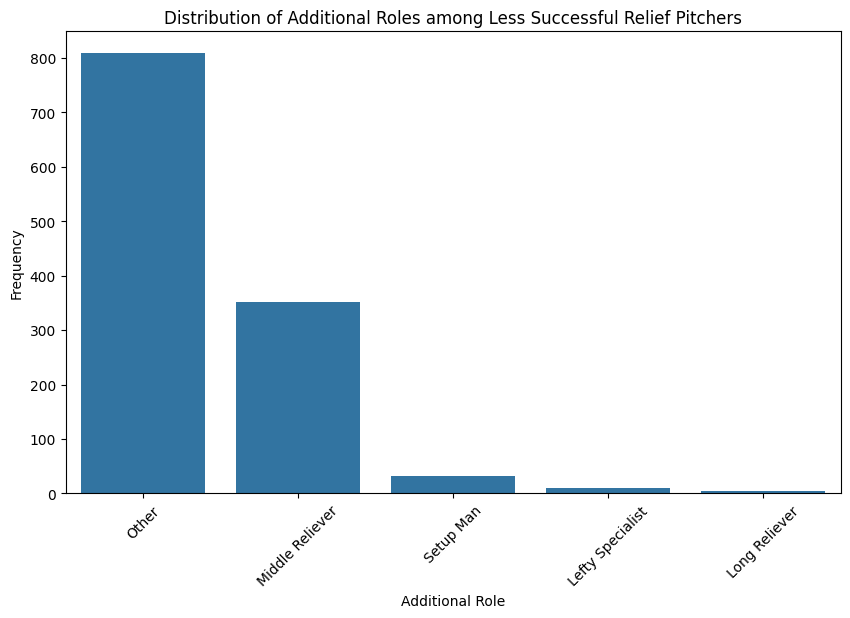

In [63]:
additional_role_counts = less_successful_rp['additional_role'].value_counts()

# Create a bar plot to visualize the distribution of additional roles
plt.figure(figsize=(10, 6))
sns.barplot(x=additional_role_counts.index, y=additional_role_counts.values)
plt.title('Distribution of Additional Roles among Less Successful Relief Pitchers')
plt.xlabel('Additional Role')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

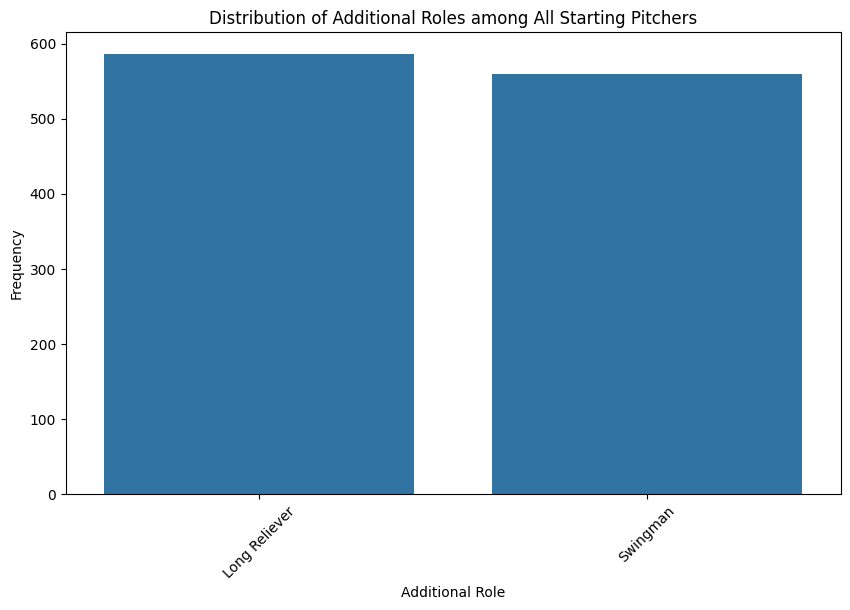

In [64]:
additional_role_counts_sp_all = starting_pitchers['additional_role'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=additional_role_counts_sp_all.index, y=additional_role_counts_sp_all.values)
plt.title('Distribution of Additional Roles among All Starting Pitchers')
plt.xlabel('Additional Role')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()



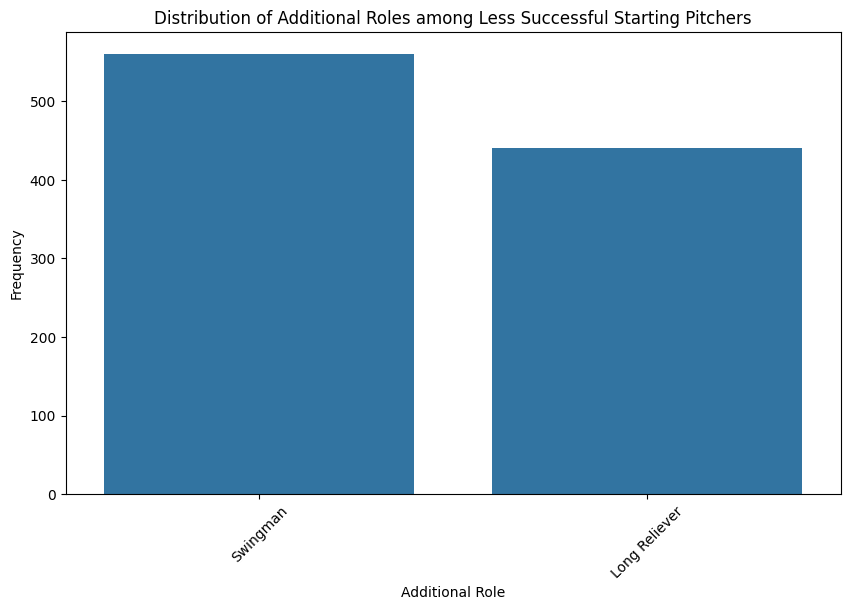

In [65]:
# Filter less successful SPs
less_successful_sp = starting_pitchers[~success_criteria_sp]

# Count the frequency of each additional role within less successful SPs
additional_role_counts_sp = less_successful_sp['additional_role'].value_counts()

# Create a bar plot to visualize the distribution of additional roles
plt.figure(figsize=(10, 6))
sns.barplot(x=additional_role_counts_sp.index, y=additional_role_counts_sp.values)
plt.title('Distribution of Additional Roles among Less Successful Starting Pitchers')
plt.xlabel('Additional Role')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


In [66]:
# List of pitcher names from the provided cluster dataframe
pitcher_names = [
    "Blake Snell", "Brandon Woodruff", "Clayton Kershaw",
    "Gerrit Cole", "Cole Ragans", "Tarik Skubal"
]

selected_pitchers = less_successful_sp[less_successful_sp['Name'].isin(pitcher_names)]



In [67]:
selected_pitchers

,PlayerId,MLBAMID,Name,NameASCII,Throws,Season,Age,Team,Role,G,...,KC,KN,PO,SC,SI,SL,ST,SV_y,release_speed,release_spin_rate
816,2036,477132,Clayton Kershaw,Clayton Kershaw,L,2021,33,LAD,SP,22,...,0.0,0.0,0.0,0.0,12.0,2523.0,0.0,0.0,86.064263,2471.907934
921,22267,669373,Tarik Skubal,Tarik Skubal,L,2021,24,DET,SP,29,...,378.0,0.0,0.0,0.0,881.0,1423.0,0.0,0.0,89.796144,2030.864446
1014,21846,666142,Cole Ragans,Cole Ragans,L,2022,24,TEX,SP,9,...,0.0,0.0,0.0,0.0,0.0,165.0,0.0,0.0,89.624476,2374.320227
1017,22267,669373,Tarik Skubal,Tarik Skubal,L,2022,25,DET,SP,21,...,378.0,0.0,0.0,0.0,881.0,1423.0,0.0,0.0,89.796144,2030.864446
1118,22267,669373,Tarik Skubal,Tarik Skubal,L,2023,26,DET,SP,15,...,378.0,0.0,0.0,0.0,881.0,1423.0,0.0,0.0,89.796144,2030.864446


In [68]:
selected_columns = selected_pitchers[['Name', 'Role', 'additional_role']]
selected_columns

,Name,Role,additional_role
816,Clayton Kershaw,SP,Long Reliever
921,Tarik Skubal,SP,Long Reliever
1014,Cole Ragans,SP,Swingman
1017,Tarik Skubal,SP,Long Reliever
1118,Tarik Skubal,SP,Long Reliever
